# Lesson: Mesh Smoothing

## Goal:

* Demonstrate how to use mesh smoothing in SIBL
* Demonstrate mesh smoothing characteristics

## *Minimum Working Example (MWE)* Mesh with Four Elements

* Load third-party modules:
  * `pyplot`
  * `numpy`
* Load the SIBL mesh library modules:
  * `mesh`
  * `mesh_smoothing`

In [16]:
import matplotlib.pyplot as plt
import numpy as np

import ptg.mesh as mesh
import ptg.mesh_smoothing as smooth

* Construct a four-element mesh with non-sequential node numbers and elements numbers, for generality.  
* Use pinned boundary conditions at the four corners:
  * `101`, `103`, `13`, `33`
* Use roller boundary conditions on the four edges:
  * `2`, `4`, `6`, `23`

```bash
^ y-axis
|
|       13       23       33 (3.0, 3.0)
         *--------*--------*
         |        |        |
         |  (44)  |  (31)  |
         |        |105     | 
       4 *--------*--------* 6
         |        |        |
         |   (1)  |  (20)  |
         |        |        |
         *--------*--------*
        101       2       103
     (1.0, 1.0)


+ --> x-axis
```

In [17]:
nodes = {
    "101": (1.0, 1.0),
    "2": (2.0 + 0.5, 1.0),
    "103": (3.0, 1.0),
    "4": (1.0, 2.0 + 0.5),
    "105": (2.0 + 0.5, 2.0 + 0.5),
    "6": (3.0, 2.0 + 0.5),
    "13": (1.0, 3.0),
    "23": (2.0 + 0.5, 3.0),
    "33": (3.0, 3.0),
}

elements = (
    (1, 101, 2, 105, 4),
    (20, 2, 103, 6, 105),
    (31, 105, 6, 33, 23),
    (44, 4, 105, 23, 13)
)  # right hand rule

boundary_nodes = {
    "101": (True, True),
    "2": (False, True),
    "103": (True, True),
    "4": (True, False),
    "6": (True, False),
    "13": (True, True),
    "23": (False, True),
    "33": (True, True),
}

### Plot the mesh in the initial configuration

In [18]:
elements_wo_element_number = tuple([x[1:] for x in elements])
elements_wo_element_number

((101, 2, 105, 4), (2, 103, 6, 105), (105, 6, 33, 23), (4, 105, 23, 13))

In [19]:
    edges = mesh.adjacencies_upper_diagonal(xs=elements_wo_element_number)
    edges

((2, 101),
 (2, 105),
 (4, 105),
 (4, 101),
 (2, 103),
 (6, 103),
 (6, 105),
 (6, 33),
 (23, 33),
 (23, 105),
 (13, 23),
 (4, 13))

In [20]:
def plot_mesh(*, nodes, edges, title:str="title"):
    (ix, iy) = (0, 1)  # global index with (x, y) semantic

    fig = plt.figure(figsize=(3.0, 3.0), dpi=100)
    # ax = plt.gca()
    ax = fig.gca()

    for edge in edges:
        edge_points = [nodes[ii] for ii in map(str, edge)]
        # xs = [nodes[e - 1][ix] for e in edge]  # nodes[e-1] to convert from 1-index to 0-index
        # ys = [nodes[e - 1][iy] for e in edge]
        xs = [point[ix] for point in edge_points]
        ys = [point[iy] for point in edge_points]
        # plt.plot(xs, ys, **plot_kwargs)
        plt.plot(
            xs,
            ys,
            alpha=1.0,
            linewidth=0.5,
            color="blue",
            marker=None,
            markerfacecolor="red",
        )

    ax.set_aspect("equal")
    ax.set_title(title)
    
    # plot nodes
    xs = [item[ix] for item in nodes.values()]
    ys = [item[iy] for item in nodes.values()]
    ax.scatter(
        xs,
        ys,
        linestyle="solid",
        edgecolor="black",
        color="yellow",
        alpha=0.9,
        s=100,
    )
    
    # plot node numbers
    for item in nodes.items():
        c = item[0]
        x = item[1][ix]
        y = item[1][iy]
        ax.text(x, y, c, horizontalalignment="center", verticalalignment="center")


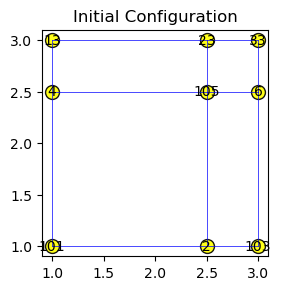

In [21]:
plot_mesh(nodes=nodes, edges=edges, title="Initial Configuration")

### Do a single mesh smoothing iteration and plot the updated configuration

In [22]:
deltas = smooth.smooth_neighbor_nonweighted(
    nodes=nodes, elements=elements, boundary_nodes=boundary_nodes, update_ratio=0.5
)

In [23]:
deltas

{'101': (0.0, 0.0),
 '2': (-0.16666666666666674, 0.0),
 '103': (0.0, 0.0),
 '4': (0.0, -0.16666666666666674),
 '105': (-0.125, -0.125),
 '6': (0.0, -0.16666666666666674),
 '13': (0.0, 0.0),
 '23': (-0.16666666666666674, 0.0),
 '33': (0.0, 0.0)}

In [24]:
def sum_of_deltas_L2_norm(*, displacements):
    sum = 0.0
    for key, value in displacements.items():
        sum += np.linalg.norm(value)
    # print(f"Sum of L2 norm of displacements: {sum}")
    return sum

In [25]:
sum_of_deltas_L2_norm(displacements=deltas)

0.8434433619633038

In [26]:
updated_configuration = {}
for key, value in nodes.items():
    updated_configuration[key] = np.array(nodes[key]) + np.array(deltas[key])

In [27]:
updated_configuration

{'101': array([1., 1.]),
 '2': array([2.33333333, 1.        ]),
 '103': array([3., 1.]),
 '4': array([1.        , 2.33333333]),
 '105': array([2.375, 2.375]),
 '6': array([3.        , 2.33333333]),
 '13': array([1., 3.]),
 '23': array([2.33333333, 3.        ]),
 '33': array([3., 3.])}

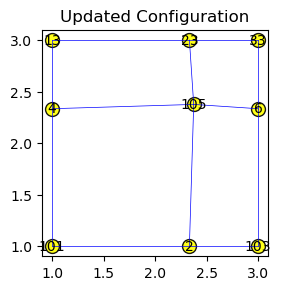

In [28]:
plot_mesh(nodes=updated_configuration, edges=edges, title="Updated Configuration")

### Do *k* mesh smoothing iterations

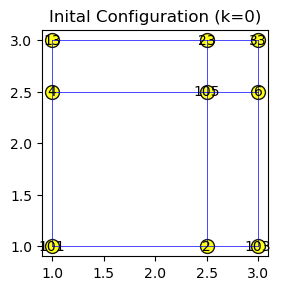

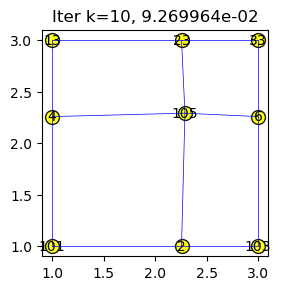

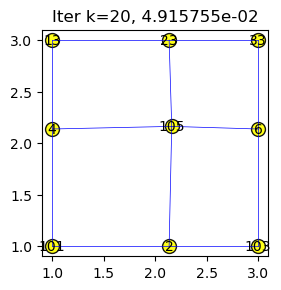

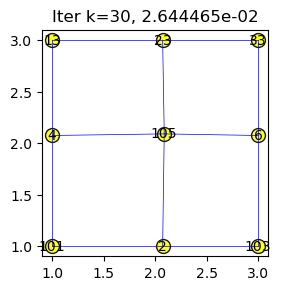

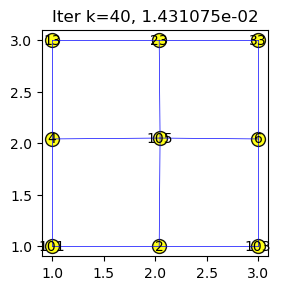

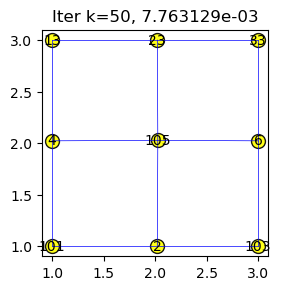

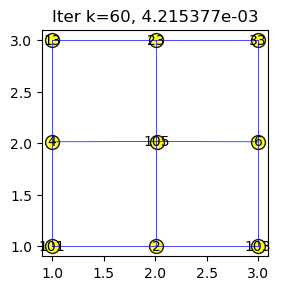

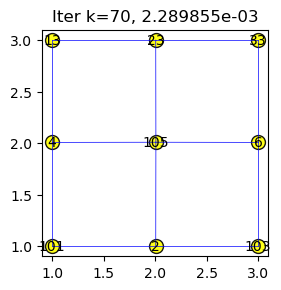

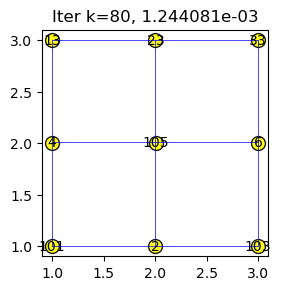

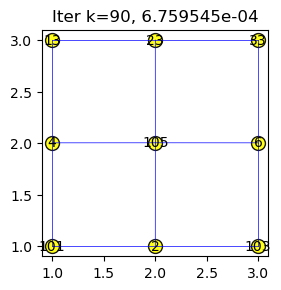

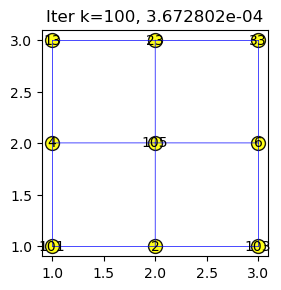

In [29]:
ur = 0.1  # update ratio
n_iterations = 100
plot_interval = 10

# The k=0 iteration is the initial configuration
configuration_k = {}
for key, value in nodes.items():
    configuration_k[key] = np.array(nodes[key]) 
plot_mesh(nodes=configuration_k, edges=edges, title="Inital Configuration (k=0)")

iteration_log = []
L2_log = []

for k in range(1, n_iterations+1):

    deltas_k = smooth.smooth_neighbor_nonweighted(
        nodes=configuration_k,
        elements=elements,
        boundary_nodes=boundary_nodes,
        update_ratio=ur
    )
    L2 = sum_of_deltas_L2_norm(displacements=deltas_k)
    iteration_log.append(k)
    L2_log.append(L2)

    L2_str = format(L2, "e")
    title_str = f"Iter k={k}, " + L2_str

    # overwrite old configuration with updated configuration
    for key, value in configuration_k.items():
        configuration_k[key] += deltas_k[key]

    if not(k % plot_interval):
        plot_mesh(nodes=configuration_k, edges=edges, title=title_str)

    


Text(0.5, 1.0, 'Convergence')

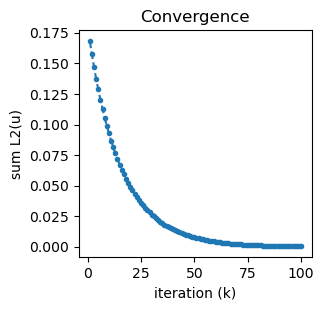

In [30]:
fig = plt.figure(figsize=(3.0, 3.0), dpi=100)
ax = fig.gca()

plt.plot(iteration_log, L2_log, '.--')
ax.set_xlabel("iteration (k)")
ax.set_ylabel("sum L2(u)")
ax.set_title("Convergence")